# 2 урок: BackTest

# Что будем делать?

- алгоритм BackTest'a
- данные
- подготовка и имплементация
- пример использования
- советы

# Алгоритм BackTest'а

1. Соединение исторических данных и предсказаний
2. Преобразование данных
   - нормирование значений метрик на траффик
   - группировка по уровню, на котором хотим считать BackTest (`sku_id`, `item_id`, `group_id`)
3. Поиск "ближайшего" маркапа (по `epsilon`) для тестового и контрольного алгоритма
4. Получение таблицы со статистикой

# Подготовка

### Импортируем библиотеки, объявляем логгер

In [1]:
from typing import List, Dict, Any, Tuple, Union, Optional

import pandas as pd

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig()
logger = logging.getLogger("back_test")
logger.setLevel(logging.INFO)

### Объявляем enum-объекты

In [2]:
from enum import Enum
from typing import List


class BackTestAlgo(str, Enum):
    epsilon_greedy_sum = "epsilon_greedy_sum"

    @classmethod
    def to_list(cls) -> List[str]:
        return list(map(lambda c: c.value, cls))  # type: ignore


class BackTestLevel(str, Enum):
    group_1 = "group_1"
    item_id = "item_id"
    sku_id = "sku_id"

    @classmethod
    def to_list(cls) -> List[str]:
        return list(map(lambda c: c.value, cls))  # type: ignore


class BackTestMetric(str, Enum):
    revenue = "revenue"  # выручка
    margin = "margin"  # прибыль

    @classmethod
    def to_list(cls) -> List[str]:
        return list(map(lambda c: c.value, cls))  # type: ignore


### Пишем вспомогательные функции

In [3]:
DS_FMT = "%Y%m%d"


def get_ds_list(ds_ranges: List[Union[Tuple[str, str], str]]) -> List[str]:
    """
    Возвращает список всех дат, которые лежат в ds_ranges
    Например, при ds_ranges = [('20220801', '20220803')] возвращает ['20220801', '20220801', '20220803']
    """
    ds_list = []
    for ds_range in ds_ranges:
        if isinstance(ds_range, tuple):
            start, end = ds_range
            ds_list = [date.strftime(DS_FMT) for date in pd.date_range(start, end)]
            ds_list.extend(ds_list)
        elif isinstance(ds_range, str):
            ds_list.append(ds_range)
        else:
            raise ValueError(
                "You should set `ds_ranges` as in example: "
                "[('20220801', '20220802')] or "
                "[('20220801', '20220802'), '20220804']"
            )
    return ds_list

In [4]:
def calculate_uplifts(
    df: pd.DataFrame,
    metric: BackTestMetric,
    index: str = "ds",
) -> Tuple[float, float]:
    """
    Возвращает аплифты по метрике:
    1 (ds_uplift) - считаются аплифты по каждому дню отдельно, затем усредняются
    2 (uplift) - суммируются значения по метрики по каждому дню в каждой группе отдельно, считается финальный аплифт
    """
    test_df = df[df["algo"] == "test"]
    test_df = test_df[[index, metric]].rename(columns={metric: "test"})

    control_df = df[df["algo"] == "control"]
    control_df = control_df[[index, metric]].rename(columns={metric: "control"})

    df = control_df.merge(test_df, on=[index], how="left")
    ds_uplift = round((df["test"] / df["control"] - 1).mean() * 100, 2)
    uplift = round(df["test"].sum() * 100 / df["control"].sum() - 100, 2)
    return ds_uplift, uplift


def plot_metric_uplift(
    df: pd.DataFrame,
    metric: BackTestMetric,
    ax: plt.Axes,
    cum_sum: bool = False,
    index: str = "ds",
) -> None:
    """
    Рисует график аплифта по метрике (сравнение контрольной и тестовой группы)
    """
    df = df.sort_values(["algo", index])
    ds_uplift, uplift = calculate_uplifts(df=df, metric=metric, index=index)
    text = f"Uplift `{metric}`" f"\n{ds_uplift}% (by ds), {uplift}% (cum)"
    if cum_sum:
        df[metric] = df.groupby("algo")[metric].cumsum()
    df_pivot = df.pivot(index=index, columns="algo", values=metric)
    for algo in df_pivot.columns:
        ax.plot(df_pivot.index, df_pivot[algo], label=algo)
    ax.set_ylabel(metric)
    ax.set_title(text)
    logger.info(text)
    ax.grid()
    ax.tick_params(labelrotation=60)
    ax.legend()


def plot_metrics_uplifts(
    df: pd.DataFrame,
    metrics: List[BackTestMetric],
    cum_sum: bool = False,
    index: str = "ds",
) -> None:
    """
    Рисует графики аплифтов по метрикам (сравнение контрольной и тестовой группы)
    """
    metrics_num = len(metrics)
    fig, axes = plt.subplots(nrows=1, ncols=metrics_num, figsize=(20, 5))
    if metrics_num == 1:
        plot_metric_uplift(df=df, metric=metrics[0], cum_sum=cum_sum, index=index, ax=axes)
    else:
        for metric, ax in zip(metrics, axes):
            plot_metric_uplift(df=df, metric=metric, cum_sum=cum_sum, index=index, ax=ax)
    plt.show()

# Данные

### Исторические данные АБ тестов

| Колонка        | Пояснение                                                                              |
|----------------|----------------------------------------------------------------------------------------|
| `sku_id`       | stock keeping unit «единица складского учёта» - идентификатор товарной позиции (артикул) |
| `group_id`      | группа / категория, в которую входит товар (может быть сколько угодно)                 |
| `markup`       | реальная наценка в этот день                                                          |
| `revenue`      | выручка или другая любая метрика / метрики                                            |
| `traffic`      | процент трафика для будущей нормировки значений метрик                                |
| `ab_test_id`   | идентификатор АБ группы                                                               |
| `ds`           | дата                                                                                  |

In [5]:
ab_df = pd.read_parquet("./data/simulated_data.parquet")
ab_df["ds"] = ab_df["ds"].astype(str)
ab_df["margin"] = ab_df["markup"] * ab_df["revenue"] # считаем margin, как наценка, умноженная на revenue
ab_df.head()

,group_1,sku_id,ab_test_id,markup,revenue,traffic,orders_num,ds,margin
0,group_1000,sku_100000,ab_100000,0.01,2539.41,0.05,1.0,20231008,25.3941
1,group_1001,sku_100001,ab_100001,0.02,6057.44,0.05,3.0,20231008,121.1488
2,group_1002,sku_100002,ab_100002,0.01,541.35,0.05,8.0,20231008,5.4135
3,group_1002,sku_100003,ab_100003,0.06,697.70,0.05,0.0,20231008,41.8620
4,group_1001,sku_100004,ab_100004,0.01,1413.99,0.05,0.0,20231008,14.1399


In [6]:
ab_df.describe().round(2)

,markup,revenue,traffic,orders_num,margin
count,511813.00,511813.00,511813.00,511813.00,511813.00
mean,0.03,18887.00,0.05,15.21,574.85
std,0.02,128869.40,0.00,77.64,4279.78
min,0.01,0.16,0.05,0.00,0.00
25%,0.01,629.79,0.05,1.00,14.57
50%,0.03,2527.34,0.05,3.00,62.75
75%,0.06,10132.01,0.05,9.00,273.41
max,0.06,33081359.06,0.05,15701.00,1984881.54


<font color="red">- наценки варьируются от 1% до 6%</font>

<font color="red">- имеем значения по 3 метрикам: revenue, orders_num и margin</font>

### Предсказания наценки тестового алгоритма
Предположим, что хотим проверить алгоритм, который всем выставляет 5% наценки

In [7]:
ds_df = pd.DataFrame({"ds": ab_df["ds"].unique().tolist()})
group_df = ab_df[["group_1"]].drop_duplicates()
test_df = ds_df.join(group_df, how="cross")
test_df["markup"] = 0.05
test_df.head()

,ds,group_1,markup
0,20231008,group_1000,0.05
1,20231008,group_1001,0.05
2,20231008,group_1002,0.05
3,20231008,group_1003,0.05
4,20231008,group_1004,0.05


### Предсказания наценки контрольного алгоритма
Контрольный алгоритм - всем товарам выставляется 1% наценки

In [8]:
control_df = test_df.copy()
control_df["markup"] = 0.01
control_df.head()

,ds,group_1,markup
0,20231008,group_1000,0.01
1,20231008,group_1001,0.01
2,20231008,group_1002,0.01
3,20231008,group_1003,0.01
4,20231008,group_1004,0.01


<font color="red"> Гипотеза: так как в тестовом алгоритме ставим маркап больше, то ожидаем положительный аплифт по прибыли и отрицательный по выручке </font>

# Имплементация

### 1. Соединение исторических данных и предсказаний

| Колонка        | Пояснение                                                                              |
|----------------|----------------------------------------------------------------------------------------|
| `sku_id`       | stock keeping unit «единица складского учёта» - идентификатор товарной позиции (артикул) |
| `group_id`      | группа / категория, в которую входит товар (может быть сколько угодно)                 |
| `markup`       | реальная наценка в этот день                                                          |
| `control_markup` | наценка контрольного алгоритма в этот день                                           |
| `test_markup`  | наценка тестового алгоритма в этот день                                               |
| `revenue`      | выручка или другая любая метрика / метрики                                            |
| `traffic`      | процент трафика для будущей нормировки значений метрик                                |
| `ab_test_id`   | идентификатор АБ группы                                                               |
| `ds`           | дата                                                                                  |

In [9]:
def combine_history_and_predictions(
    df: pd.DataFrame,
    control_df: pd.DataFrame,
    test_df: pd.DataFrame,
) -> pd.DataFrame:
    """
    Возвращается один датасет с колонками `control_markup` и `test_markup`
    """
    def set_markup(
        prefix: str,
        df: pd.DataFrame,
        group_df: pd.DataFrame,
    ) -> pd.DataFrame:
        group_df = group_df.rename(columns={"markup": f"{prefix}_markup"})
        common_cols = list(set(group_df.columns).intersection(set(df.columns)))
        logger.info(f"Start joining {prefix} df on {common_cols}")
        df = df.merge(group_df, how="left", on=common_cols)
        return df

    df = set_markup(
        prefix="control",
        df=df,
        group_df=control_df,
    )
    df = set_markup(
        prefix="test",
        df=df,
        group_df=test_df,
    )
    return df

### 2. Преобразование данных

- нормирование значений метрик на траффик
- группировка по уровню, на котором хотим считать BackTest (`sku_id`, `item_id`, `group_id`)
| Колонка        | Пояснение                                                                              |
|----------------|----------------------------------------------------------------------------------------|
| `sku_id`, `group_id`       | уровень |
| `markup`       | реальная наценка в этот день                                                          |
| `control_markup` | наценка контрольного алгоритма в этот день                                           |
| `test_markup`  | наценка тестового алгоритма в этот день                                               |
| `revenue`      | выручка или другая любая метрика / метрики                                            |
| `ds`           | дата                                                                                  |

In [10]:
def postprocess(
    df: pd.DataFrame,
    lvl: str,
    metrics: List[BackTestMetric],
) -> pd.DataFrame:
    """
    Возвращается преобразованный датасет, исходя из того, на каком уровне проводится BackTest,
    усредняются значения наценок на выбранном уровне
    """
    agg_funcs = {metric: "sum" for metric in metrics}
    agg_funcs.update(
        {
            "markup": "mean",
            "control_markup": "mean",
            "test_markup": "mean",
            "traffic": "mean",
        }
    )
    # агрегация для подсчета метрик на заданном уровне
    df = df.groupby(["ds", lvl, "ab_test_id"]).agg(agg_funcs).reset_index()
    for metric in metrics:
        df[metric] = df[metric] / df["traffic"]
    df = df.round(2) # для того, чтобы считать наценку 0.057 и 0.058 одинаковой - 0.06
    agg_funcs = {metric: "mean" for metric in metrics}
    agg_funcs.update(
        {
            "control_markup": "mean",
            "test_markup": "mean",
        }
    )
    # агрегация для подсчета метрик без учета АБ тестов
    df = df.groupby(["ds", lvl, "markup"]).agg(agg_funcs).reset_index()
    df = df.round(2)
    return df

### 3. Поиск "ближайшего" маркапа (по `epsilon`) для тестового и контрольного алгоритма

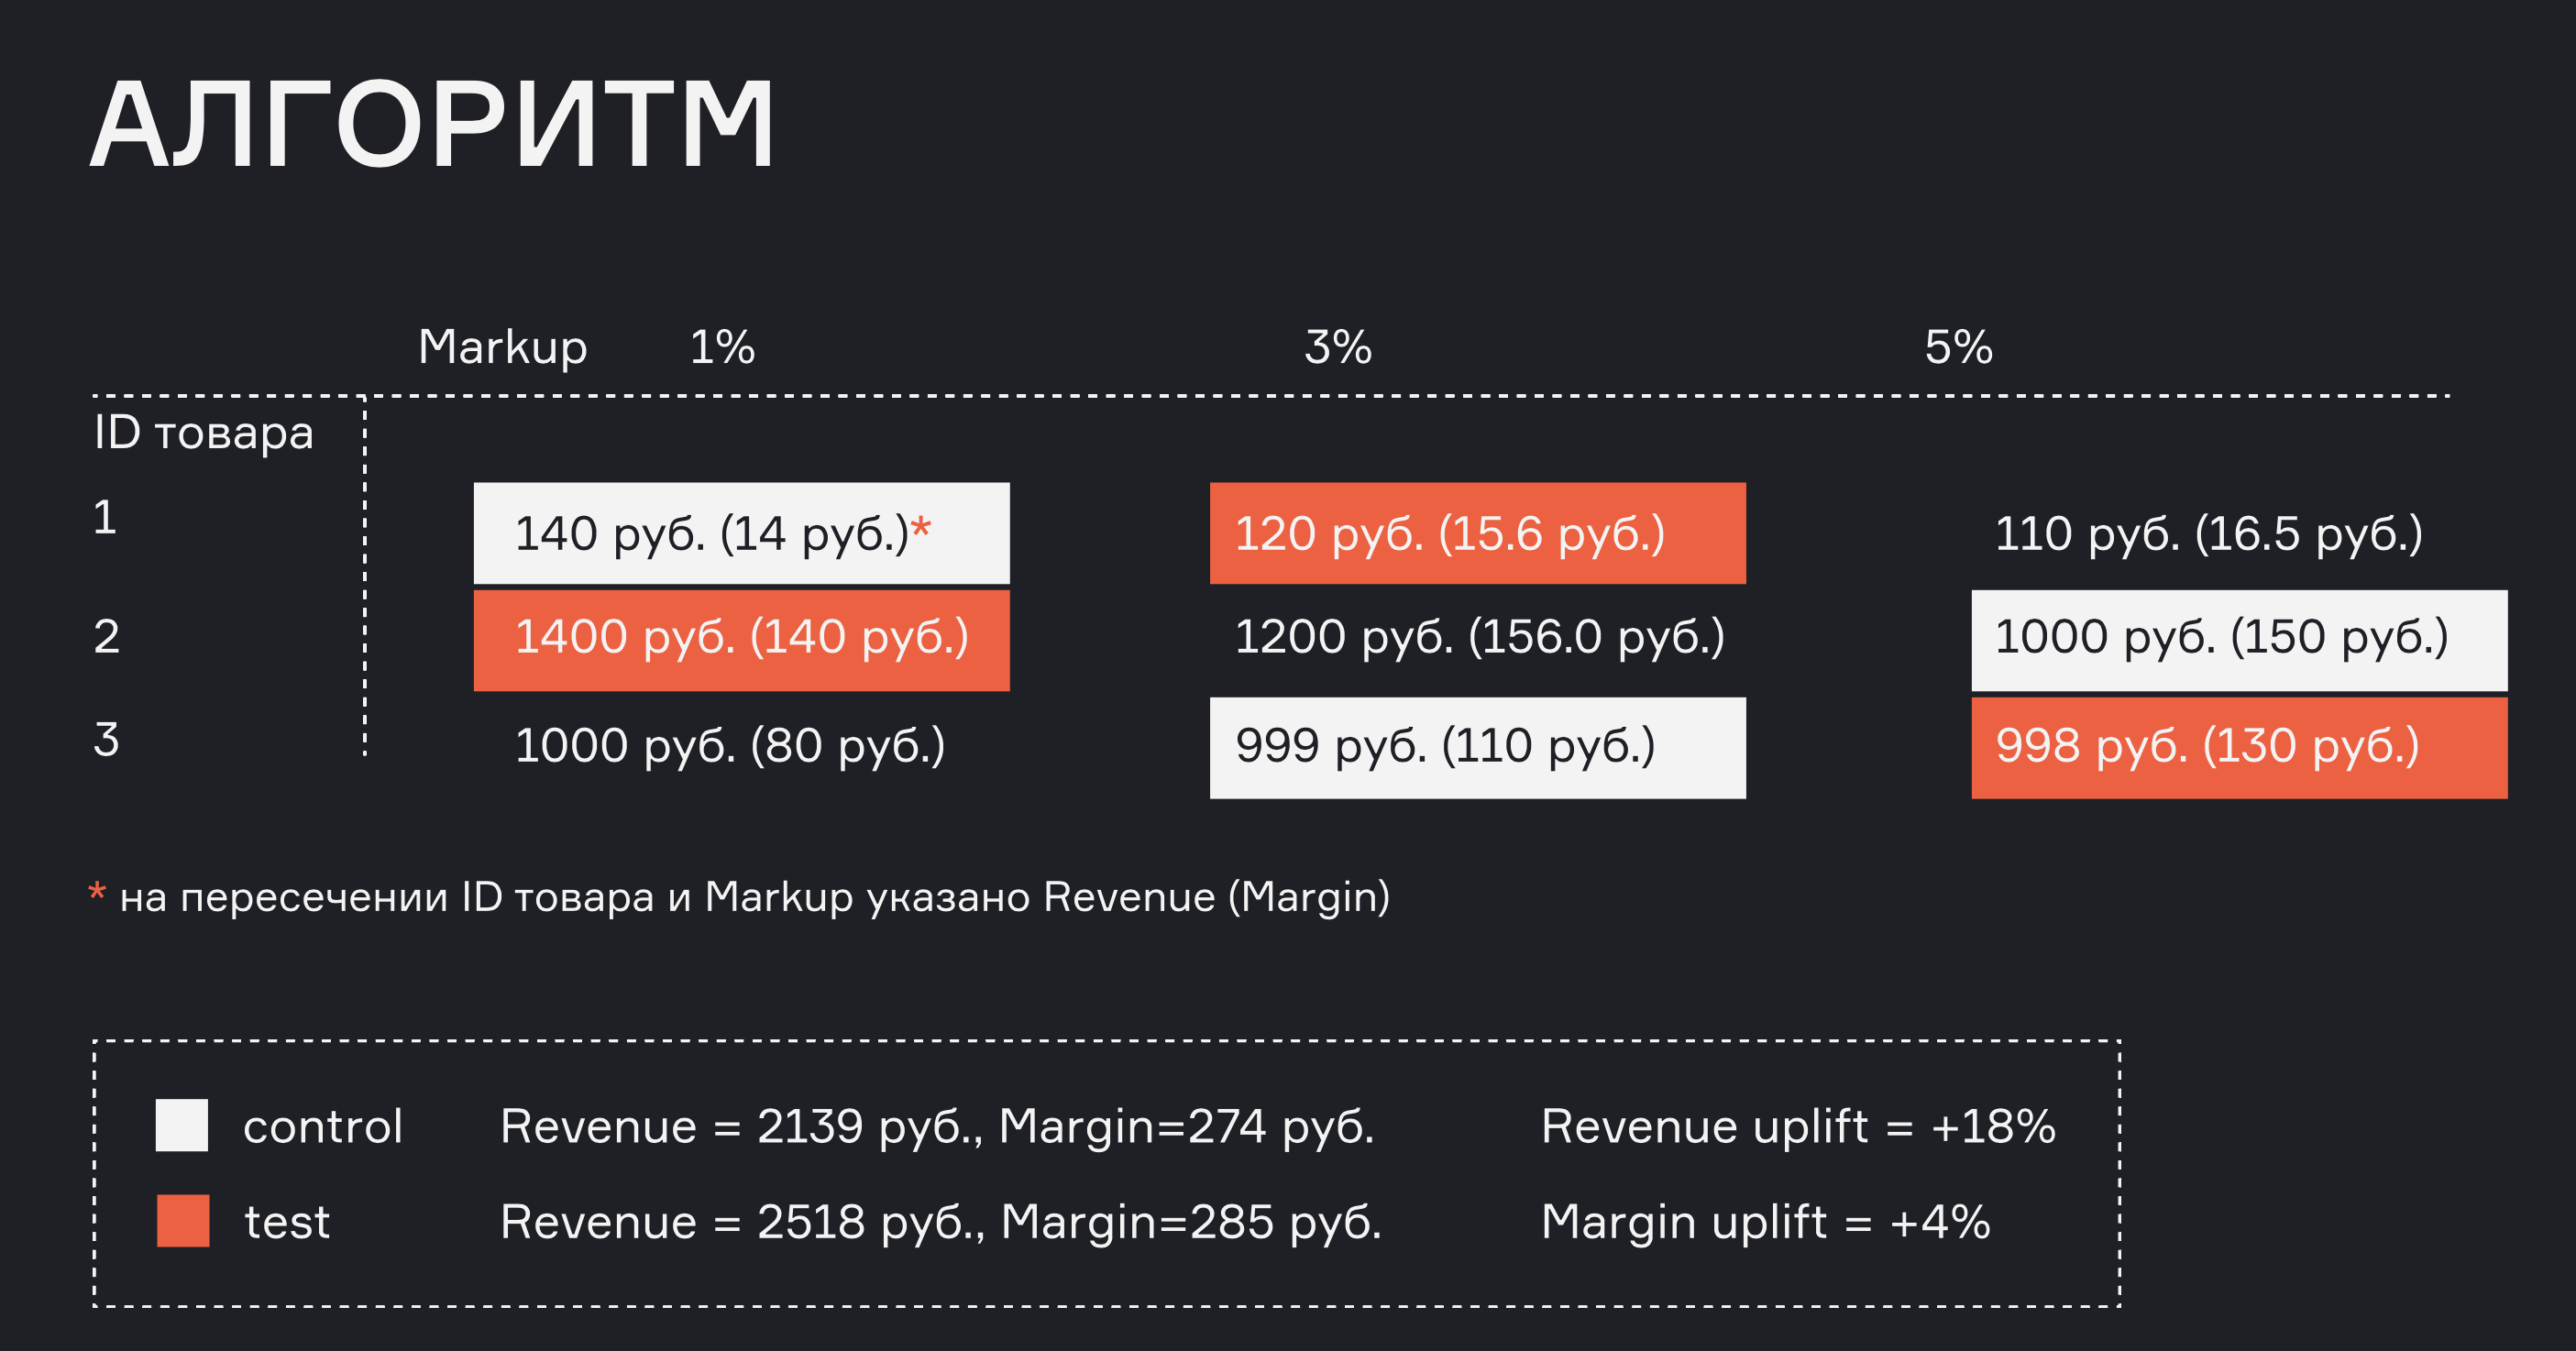

In [11]:
from IPython.display import Image

Image("./images/back_test_algo.png", width=700, height=400)

   - `markup` между `test_markup - epsilon` и `test_markup + epsilon`
| Колонка        | Пояснение                                                                              |
|----------------|----------------------------------------------------------------------------------------|
| `sku_id`, `group_id`       | уровень |
| `test_markup`  | наценка тестового алгоритма в этот день                                               |
| `revenue` -> `test_revenue`| предсказанная выручка тестового алгоритма в этот день                                           |
| `ds` | дата                                           |
   - `markup` между `control_markup - epsilon` и `control_markup + epsilon`
| Колонка        | Пояснение                                                                              |
|----------------|----------------------------------------------------------------------------------------|
| `sku_id`, `group_id`       | уровень |
| `control_markup`  | наценка контрольного алгоритма в этот день                                               |
| `revenue` -> `control_revenue`| предсказанная выручка контрольного алгоритма в этот день                                           |
| `ds` | дата                                           |

### 4. Получение таблицы со статистикой

| Колонка        | Пояснение                                                                              |
|----------------|----------------------------------------------------------------------------------------|
| `sku_id`, `group_id`       | уровень |
| `control_markup` | наценка контрольного алгоритма в этот день                                           |
| `test_markup`  | наценка тестового алгоритма в этот день                                               |
| `control_revenue` | предсказанная выручка контрольного алгоритма в этот день                                           |
| `test_revenue`  | предсказанная выручка тестового алгоритма в этот день                                               |
| `ds`           | дата                                                                                  |

In [12]:
class EpsilonGreedySum:
    def __init__(
        self,
        epsilon: float = 0.005,
        do_show_intersection: bool = True,
    ):
        """
        epsilon - разница между наценками, которую считаем незначимой
        do_show_intersection - показывать ли пересечение исторических и предсказанных наценок:
        - если высокий процент, то BackTest'у можно доверять
        - если низкий процент, то недостаточно данных для проведения BackTest'a
        """
        self.epsilon = epsilon
        self.do_show_intersection = do_show_intersection

    def calculate_group_metrics(
        self,
        df: pd.DataFrame,
        lvl: str,
        prefix: str,
        metrics: List[BackTestMetric],
    ) -> pd.DataFrame:
        """
        Считает предсказания по метрикам с учетом epsilon
        Calculates predictions for given markup. The right algorithm's markup is defined as closest to real A/B test markup with +/- epsilon distance to it
        """

        # Only those A/B test markups are left that are between corresponding Algorithm's Markup (+/- defined epsilon)
        df_filtered = df[
            df["markup"].between(
                df[f"{prefix}_markup"] - self.epsilon,
                df[f"{prefix}_markup"] + self.epsilon,
            )
        ]

        # Get dictionary of metric and corresponding aggregation function (mean)
        agg_functions = {metric: "mean" for metric in metrics}

        # Group by date (ds), level (group_1) and algorithm's markup (algo_1_markup) and aggregate using the aggregations provided above
        stats_df = (
            df_filtered.groupby(["ds", lvl, f"{prefix}_markup"])
            .agg(agg_functions)
            .reset_index()
        )

        # Rename the columns
        stats_df = stats_df.rename(
            columns={metric: f"{prefix}_{metric}" for metric in metrics}
        )

        # Round the numbers
        stats_df = stats_df.round(2)

        return stats_df

    @staticmethod
    def show_intersection(
        lvl: str,
        control_stats_df: pd.DataFrame,
        test_stats_df: pd.DataFrame,
        stats_df: pd.DataFrame,
    ) -> None:
        """
        Показывает пересечение исторических и предсказанных наценок:
        - если высокий процент, то BackTest'у можно доверять
        - если низкий процент, то недостаточно данных для проведения BackTest'a
        """
        control_distinct_df = (
            control_stats_df.groupby("ds")[lvl].nunique().reset_index(name="control")
        )
        test_distinct_df = (
            test_stats_df.groupby("ds")[lvl].nunique().reset_index(name="test")
        )
        inter_distinct_df = (
            stats_df.groupby("ds")[lvl].nunique().reset_index(name="inter")
        )

        distinct_df = pd.merge(
            test_distinct_df, control_distinct_df, how="left", on=["ds"]
        )
        distinct_df = pd.merge(distinct_df, inter_distinct_df, how="left", on=["ds"])

        distinct_df["inter / test"] = distinct_df["inter"] / distinct_df["test"]
        distinct_df["inter / control"] = distinct_df["inter"] / distinct_df["control"]

        logger.info(f"Unique {lvl} intersection:\n{distinct_df.to_markdown()}")
        mean_distinct_df = distinct_df.drop(columns=["ds"]).mean().round(2)
        logger.info(f"Mean unique {lvl} intersection:\n{mean_distinct_df.to_markdown()}")

    def calculate_groups_metrics(
        self,
        df: pd.DataFrame,
        lvl: str,
        metrics: List[BackTestMetric],
    ) -> pd.DataFrame:
        """
        1) Считает для каждой группы предсказания по метрикам с учетом epsilon
        2) Показывает пересечение исторических и предсказанных наценок
        """

        # Gets predicitons for each algorithm's markup by considering real data from A/B test where those real markups are selected that are within +/- epsilon distance from algorithm's markup
        control_stats_df = self.calculate_group_metrics(
            df=df,
            lvl=lvl,
            prefix="control",
            metrics=metrics,
        )

        test_stats_df = self.calculate_group_metrics(
            df=df,
            lvl=lvl,
            prefix="test",
            metrics=metrics,
        )

        # Get list of columns that are both present in TEST and CONTROL datasets
        common_columns = list(
            set(control_stats_df.columns).intersection(set(test_stats_df.columns))
        )

        # Join TEST and CONTROL datasets by the columns that are defined above
        stats_df = test_stats_df.merge(control_stats_df, how="inner", on=common_columns)

        # IT'S NECESSARY TO DESCRIBE THIS PART
        if self.do_show_intersection:
            self.show_intersection(
                lvl=lvl,
                control_stats_df=control_stats_df,
                test_stats_df=test_stats_df,
                stats_df=stats_df,
            )

        return stats_df

    @staticmethod
    def calculate_statistics(df: pd.DataFrame, metrics: List[BackTestMetric]) -> pd.DataFrame:
        """
        Считает значения метрик по дням для контрольной и тестовой группам
        """

        # Create an empty dicitonary with "algo" and "ds" keys
        result: Dict[str, Any] = {
            "algo": [],
            "ds": [],
        }

        # Update the dictionary with keys for each provided metric
        result.update({metric: [] for metric in metrics})

        # Define aggregation functions for each provided metric (CONTROL GROUP)
        agg_functions = {f"control_{metric}": "sum" for metric in metrics}

        # Defina aggregation funcitons for each provided metric (TEST GROUP)
        agg_functions.update({f"test_{metric}": "sum" for metric in metrics})

        # Group by date (ds) and aggregate by functions defined above
        stats_df = df.groupby("ds").agg(agg_functions).reset_index()

        # Calculate number of rows in "stats_df" dataframe (actually, it's number of unique dates in the dataset)
        stats_rows_num = stats_df.shape[0]

        # Iterate through different algorithms
        for group in ["control", "test"]:

            # Fill in "algo" key of "result" dictionary with name of algorithm
            result["algo"] += [group] * stats_rows_num

            # Iterate trhough provided metrics
            for metric in metrics:

                # Store the metric results in "result" dictionary for given metric and group
                result[metric] += stats_df[f"{group}_{metric}"].tolist()

            # Store dates in "result" dictionary for given group
            result["ds"] += stats_df["ds"].tolist()

        # Convert the dictionary to dataframe
        result_df = pd.DataFrame(data=result)

        return result_df

    def run(
        self,
        df: pd.DataFrame,
        lvl: str,
        metrics: List[BackTestMetric],
    ) -> pd.DataFrame:
        """
        Входная точка алгоритма BackTest'а на основе epsilon
        """

        # For each date, group (item category) and algorithm's markup that is close to real A/B test markup by +/- epsilon distance, calculate mean value of metric of interest
        stats_df = self.calculate_groups_metrics(df=df, lvl=lvl, metrics=metrics)

        # For each date and algorithm, calculate the metric of interest
        result_df = self.calculate_statistics(df=stats_df, metrics=metrics)

        return result_df


register = {
    "epsilon_greedy_sum": EpsilonGreedySum,
}


def run_algo(
    df: pd.DataFrame,
    lvl: BackTestLevel,
    algo: BackTestAlgo,
    metrics: List[BackTestMetric],
    algo_params: Optional[Dict[str, Any]] = None,
) -> pd.DataFrame:
    """
    Входная точка алгоритма BackTest'а
    """

    # Get class of provided algorithm
    algo_obj = register.get(algo)

    # If there's no class of algorithm, then display an error
    if algo_obj is None:
        raise ValueError(
            f"You should provide `algo` from the list: {BackTestAlgo.to_list()}"
        )

    # Get algorithm parameters if defined. Otherwise, set an empty dictionary
    algo_params = algo_params or {}

    #
    result_df = algo_obj(**algo_params).run(df=df, lvl=lvl, metrics=metrics)

    return result_df

# Пример использования

In [13]:
def get_ab_df(
    df: pd.DataFrame,
    ds_list: List[str],
    lvl: BackTestLevel,
    metrics: List[BackTestMetric],
    control_df: pd.DataFrame,
    test_df: pd.DataFrame,
) -> pd.DataFrame:
    """
    Готовит данные для BackTest'a:
    1) выбирает нужные даты
    2) соединяет исторические и предсказанные наценки
    3) преобразует датасет под заданный уровень
    """
    df = df[df["ds"].isin(ds_list)]
    df = combine_history_and_predictions(
        df=df,
        control_df=control_df,
        test_df=test_df,
    )
    df = postprocess(df=df, lvl=lvl, metrics=metrics)
    return df


def run_back_test(
    algo: BackTestAlgo,
    lvl: BackTestLevel,
    ds_ranges: List[Union[Tuple[str, str], str]],
    ab_df: pd.DataFrame,
    control_df: pd.DataFrame,
    test_df: pd.DataFrame,
    metrics: List[BackTestMetric],
    algo_params: Optional[Dict[str, Any]] = None,
):
    """
    Входная точка BackTest'а
    """
    ds_list = get_ds_list(ds_ranges=ds_ranges)
    ab_df = get_ab_df(
        df=ab_df,
        ds_list=ds_list,
        lvl=lvl,
        metrics=metrics,
        control_df=control_df,
        test_df=test_df,
    )
    result_df = run_algo(
        df=ab_df,
        algo=algo,
        lvl=lvl,
        algo_params=algo_params,
        metrics=metrics,
    )
    return result_df


In [14]:
ab_df

,group_1,sku_id,ab_test_id,markup,revenue,traffic,orders_num,ds,margin
0,group_1000,sku_100000,ab_100000,0.01,2539.41,0.05,1.0,20231008,25.3941
1,group_1001,sku_100001,ab_100001,0.02,6057.44,0.05,3.0,20231008,121.1488
2,group_1002,sku_100002,ab_100002,0.01,541.35,0.05,8.0,20231008,5.4135
3,group_1002,sku_100003,ab_100003,0.06,697.70,0.05,0.0,20231008,41.8620
4,group_1001,sku_100004,ab_100004,0.01,1413.99,0.05,0.0,20231008,14.1399
...,...,...,...,...,...,...,...,...,...
537020,group_1002,sku_101093,ab_100019,0.03,178.71,0.05,2.0,20231021,5.3613
537021,group_1012,sku_101412,ab_100013,0.03,88.71,0.05,2.0,20231021,2.6613
537022,group_1024,sku_103568,ab_100017,0.03,55.29,0.05,1.0,20231021,1.6587
537024,group_1001,sku_100697,ab_100004,0.02,8885.78,0.05,1.0,20231021,177.7156


In [15]:
ALGO = BackTestAlgo.epsilon_greedy_sum
LVL = BackTestLevel.group_1
ALGO_PARAMS = {
    "epsilon": 0.01,
    "do_show_intersection": True,
}
DS_RANGES = [("20231008", "20231021")]
METRICS = [BackTestMetric.revenue, BackTestMetric.margin]
result_df = run_back_test(
    algo=ALGO,
    lvl=LVL,
    ds_ranges=DS_RANGES,
    ab_df=ab_df,
    control_df=control_df,
    test_df=test_df,
    metrics=METRICS,
    algo_params=ALGO_PARAMS,
)
result_df.head()

INFO:back_test:Start joining control df on ['group_1', 'ds']
INFO:back_test:Start joining test df on ['group_1', 'ds']
INFO:back_test:Unique group_1 intersection:
|    |       ds |   test |   control |   inter |   inter / test |   inter / control |
|---:|---------:|-------:|----------:|--------:|---------------:|------------------:|
|  0 | 20231008 |     37 |        32 |      30 |       0.810811 |          0.9375   |
|  1 | 20231009 |     37 |        33 |      31 |       0.837838 |          0.939394 |
|  2 | 20231010 |     35 |        33 |      29 |       0.828571 |          0.878788 |
|  3 | 20231011 |     33 |        31 |      25 |       0.757576 |          0.806452 |
|  4 | 20231012 |     34 |        33 |      28 |       0.823529 |          0.848485 |
|  5 | 20231013 |     33 |        33 |      27 |       0.818182 |          0.818182 |
|  6 | 20231014 |     34 |        34 |      29 |       0.852941 |          0.852941 |
|  7 | 20231015 |     34 |        34 |      29 |       0.852941

,algo,ds,BackTestMetric.revenue,BackTestMetric.margin
0,control,20231008,3.896330e+08,5639072.51
1,control,20231009,4.945650e+08,7399178.71
2,control,20231010,5.140192e+08,8530865.17
3,control,20231011,3.928137e+08,4894105.49
4,control,20231012,5.353324e+08,8075535.75


<font color="red">Пересечение >80%, что значит, что в большинстве случаев мы имеем предсказанные наценки на истории и можем доверять нашему BackTest'у</font>

INFO:back_test:Uplift `revenue`
-6.43% (by ds), -7.92% (cum)
INFO:back_test:Uplift `margin`
163.17% (by ds), 155.16% (cum)


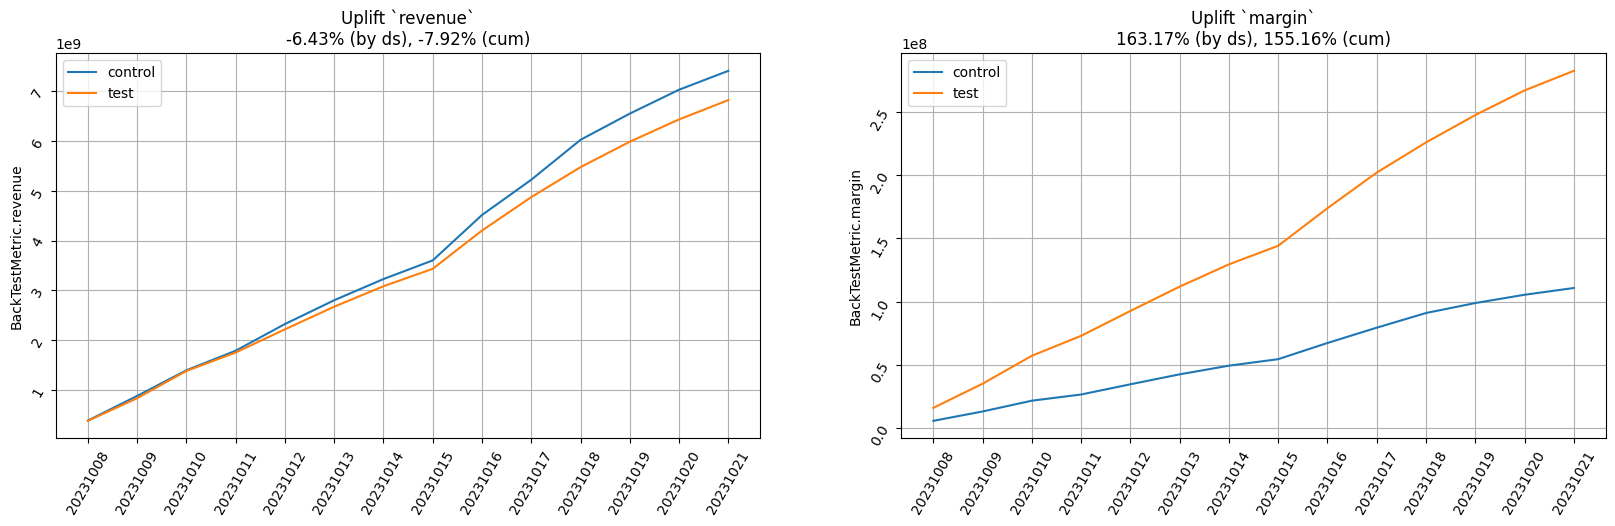

In [16]:
plot_metrics_uplifts(
    df=result_df,
    metrics=METRICS,
    cum_sum=True,
)

INFO:back_test:Uplift `revenue`
-6.43% (by ds), -7.92% (cum)
INFO:back_test:Uplift `margin`
163.17% (by ds), 155.16% (cum)


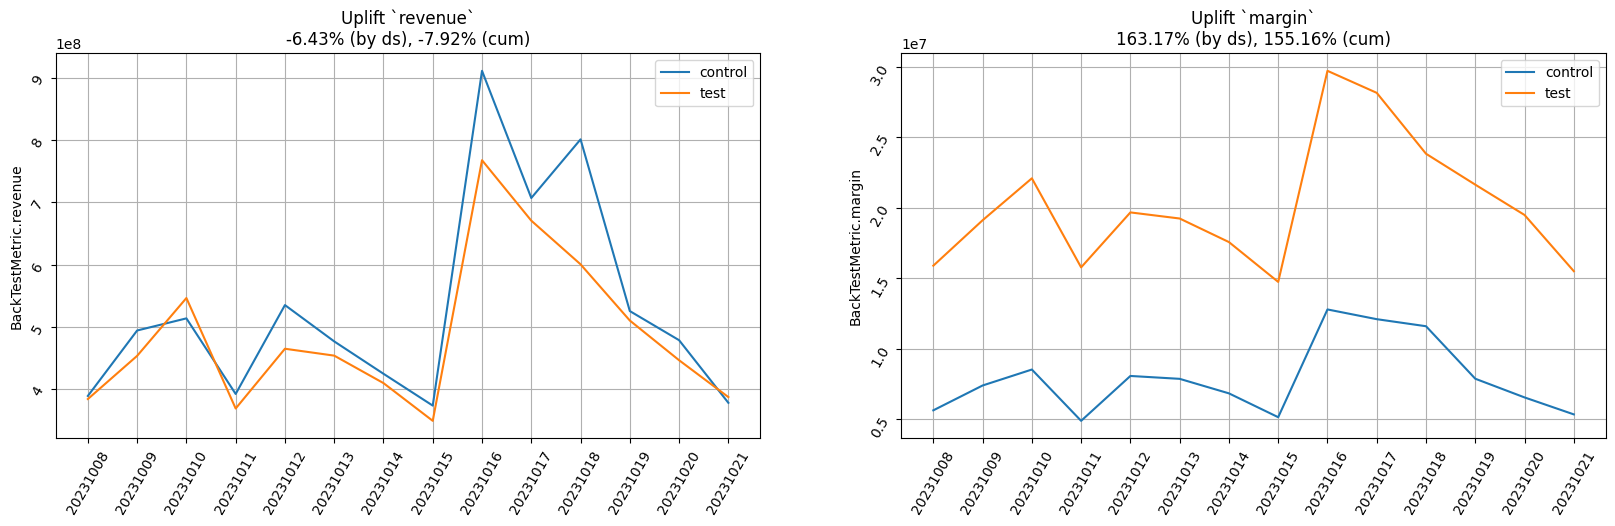

In [17]:
plot_metrics_uplifts(
    df=result_df,
    metrics=METRICS,
    cum_sum=False,
)

<font color="red">Как и предполагалось: повышая цену, мы будем выигрывать в margin (аплифт ~+155%) и проигрывать в revenue (аплифт ~-8%)</font>

# Советы
- Смотрите пересечение
    - Если пересечение маленькое и аплифт низкий - это не значает, что ваш алгорит плохой, это значит, что у вас недостаточно разнообразные данные для проведения BackTest'а ИЛИ можно перейти на уровень выше
- Не забывайте про честную оценку
    - Для BackTest'а используйте отложенную выборку, то есть ту, которая не участвовала в обучении алгоритма
    - Спрос поддвержен сезональности, поэтому лучше проводить BackTest на разных периодах и брать период не меньше периода АБ теста